# BFS: Breadth First Search

In the last reading, we learned about how to check whether there is a path from node A to node B.

In this reading, we'll explore more aspects of this problem:

1. outputing the actual path, instead of just checking what it is?
2. finding the shortest path using BFS (breadth-first search) instead of DFS (depth-first search)
3. using queues (instead of lists) to make BFS faster
4. time complexity vs. space complexity
5. priority queues, and their application to weighted edges

You can download the .ipynb form of this reading [here](lec-13-bfs.ipynb).

In [1]:
from graphviz import Graph, Digraph

## Review

Let's revisit the graph search from the end of the last reading (only change is addition of `__repr__`):

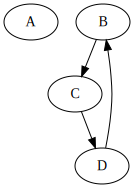

In [2]:
class mygraph:
    def __init__(self):
        self.nodes = {}
    
    def node(self, name):
        self.nodes[name] = Node(self, name)
    
    def edge(self, src, dst):
        for name in [src, dst]:
            if not name in self.nodes:
                self.node(name)
        self.nodes[src].children.append(self.nodes[dst])
        
    def _repr_svg_(self):
        g = Digraph()
        for n in self.nodes:
            g.node(n)
            for child in self.nodes[n].children:
                g.edge(n, child.name)
        return g._repr_svg_()
    
    def find(self, src, dst):
        self.visited = set()
        return self.nodes[src].find(dst)

class Node:
    def __init__(self, graph, name):
        self.graph = graph
        self.name = name
        self.children = []
        
    def __repr__(self):
        return "node %s" % self.name
        
    def find(self, dst):
        if self.name in self.graph.visited:
            return False
        self.graph.visited.add(self.name)

        if self.name == dst:
            return True
        for child in self.children:
            if child.find(dst):
                return True
        return False

g = mygraph()
g.node("A")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "B")
g

In [3]:
g.find("A", "A"), g.find("A", "B"), g.find("B", "D"), g.find("B", "A")

(True, False, True, False)

## Getting the Path

Rather than just determine if there is a path, let's output what it is.  We'll modify the `find` method.  If there's a path, it should return it as a list of nodes traversed.  If there is not a path, it should return None.

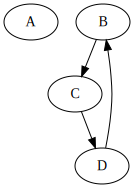

In [4]:
def find_v2(self, dst):
    if self.name in self.graph.visited:
        return None

    if self.name == dst:
        return (self.name, )

    for child in self.children:
        path = child.find(dst)
        if path != None:
            return (self.name, ) + path

    return None

# monkey patching (not recommended, but means we don't need to show the complete new version of Node)
Node.find = find_v2

g = mygraph()
g.node("A")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "B")
g

In [5]:
path = g.find("A", "B")
print(path)

None


In [6]:
path = g.find("C", "B")
print(path)

('C', 'D', 'B')


## Multiple Paths

What if there are multiple paths?  Which will we return?

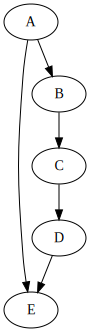

In [7]:
g = mygraph()
g.edge("A", "E")
g.edge("A", "B")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "E")
g

In [8]:
g.find("A", "E")

('A', 'E')

Nice, it found the shortest one!  But what if we build the same graphs, but adding the edges in a different order?

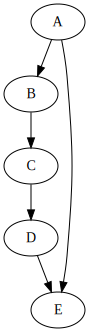

In [9]:
g = mygraph()
g.edge("A", "B")
g.edge("B", "C")
g.edge("C", "D")
g.edge("D", "E")
g.edge("A", "E") # we used to add this first, now last
g

In [10]:
g.find("A", "E")

('A', 'B', 'C', 'D', 'E')

Yuck!  If Google gave me these directions for getting from city A to E, then I might just switch to Apple Maps.

The search pattern we're using is known as "depth first search", or DFS.  It explores one child (and all it's descendents) completely before checking the other children.

The alternative to DFS is BFS, or "breadth first search".  This algorithm will explore all children before exploring grandchildren, before exploring great grandchildren, etc.

The algorithm for BFS is not recursive.  The strategy is to keep a "TODO" list of all nodes that need to be visited.  The list is a queue, meaning the first nodes added to the list will be the first ones visited.

Let's try it:

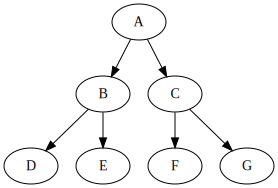

In [11]:
def find_bfs(self, dst):
    # the first node to explore is the starting point
    todo = [self]

    # keep looping while there are unexplored nodes
    while len(todo) > 0:
        print("TODO:", todo)
        curr = todo.pop(0) # pop from beginning

        print("VISITING:", curr)
        if curr.name == dst:
            return True
        else:
            for child in curr.children:
                if not child.name in self.graph.visited:
                    todo.append(child) # add to end
                    self.graph.visited.add(child.name)

    # nothing left to check, and we haven't already returned True
    return False

Node.find = find_bfs

g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g

In [12]:
g.find("A", "G")

TODO: [node A]
VISITING: node A
TODO: [node B, node C]
VISITING: node B
TODO: [node C, node D, node E]
VISITING: node C
TODO: [node D, node E, node F, node G]
VISITING: node D
TODO: [node E, node F, node G]
VISITING: node E
TODO: [node F, node G]
VISITING: node F
TODO: [node G]
VISITING: node G


True

Cool!  We're searching one level at a time.  But did you notice we lost some functionality?  We aren't keeping track of how we got to the final node.  There are often multiple ways to reach a node, so we should add a `back` attribute to backtrack how we got there.

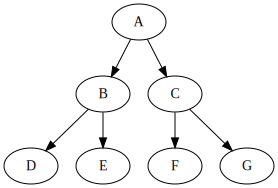

In [13]:
def backtrace(self, node):
    nodes = []
    while node != None:
        nodes.append(node)
        node = node.back
    return tuple(reversed(nodes))

def find_bfs_v2(self, dst):
    # the first node to explore is the starting point
    todo = [self]
    self.back = None
    self.graph.visited.add(self.name)

    # keep looping while there are unexplored nodes
    while len(todo) > 0:
        print("TODO:", todo)
        curr = todo.pop(0) # pop from beginning

        print("VISITING:", curr)
        if curr.name == dst:
            return backtrace(self, curr)
        else:
            for child in curr.children:
                if not child.name in self.graph.visited:
                    todo.append(child) # add to end
                    child.back = curr
                    self.graph.visited.add(child.name)
    
    # nothing left to check, and we haven't already returned True
    return None

Node.find = find_bfs_v2

g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g

In [14]:
g.find("A", "G")

TODO: [node A]
VISITING: node A
TODO: [node B, node C]
VISITING: node B
TODO: [node C, node D, node E]
VISITING: node C
TODO: [node D, node E, node F, node G]
VISITING: node D
TODO: [node E, node F, node G]
VISITING: node E
TODO: [node F, node G]
VISITING: node F
TODO: [node G]
VISITING: node G


(node A, node C, node G)

Let's make a tougher test case, with the following:
1. cycles
2. short and long paths to the same target

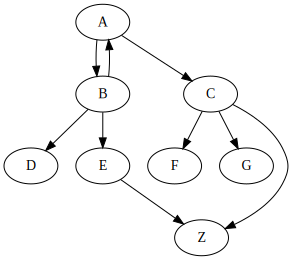

In [15]:
g.edge("E", "Z")
g.edge("C", "Z")
g.edge("B", "A")
g

Now there are two A-to-Z paths:
* A,B,E,Z
* A,C,Z

We ought to find the second one!

In [16]:
g.find("A", "Z")

TODO: [node A]
VISITING: node A
TODO: [node B, node C]
VISITING: node B
TODO: [node C, node D, node E]
VISITING: node C
TODO: [node D, node E, node F, node G, node Z]
VISITING: node D
TODO: [node E, node F, node G, node Z]
VISITING: node E
TODO: [node F, node G, node Z]
VISITING: node F
TODO: [node G, node Z]
VISITING: node G
TODO: [node Z]
VISITING: node Z


(node A, node C, node Z)

Just what we wanted.

## Optimization: Queues

In our code above, we have two ways to modify `todo`:
* `todo.append(child)`, which is O(1)
* `curr = todo.pop(0)`, which is O(N)

A queue is a list-like structure optimized for popping from the front and appending to the end.  In Python, `deque` is a good queue implementation:

https://docs.python.org/3/library/collections.html#collections.deque

Let's use it (focus on the changes identified in the comments):

In [17]:
from collections import deque # CHANGE 1: import it

def find_bfs_v3(self, dst):
    todo = deque([self]) # CHANGE 2: deque instead of list
    self.back = None
    self.graph.visited.add(self.name)

    # keep looping while there are unexplored nodes
    while len(todo) > 0:
        curr = todo.popleft() # CHANGE 3: .popleft instead of .pop(0)

        if curr.name == dst:
            return backtrace(self, curr)
        else:
            for child in curr.children:
                if not child.name in self.graph.visited:
                    todo.append(child) # NON-CHANGE 4: append is the same
                    child.back = curr
                    self.graph.visited.add(child.name)
    
    return None

Node.find = find_bfs_v3

g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g.edge("E", "Z")
g.edge("C", "Z")
g.edge("B", "A")
g.find("A", "Z")

(node A, node C, node Z)

Same result, but it will be faster for large graphs.

## Non-Recursive DFS

We can tweak the BFS code to get a non-recursive depth-first search algorithm.

Instead of popping from the beginning of `todo`, we just pop from the end:

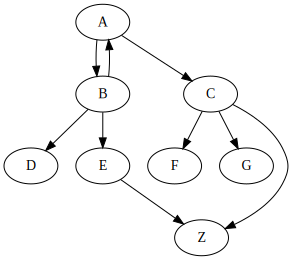

In [18]:
def find_dfs(self, dst):
    todo = deque([self])
    self.back = None
    self.graph.visited.add(self.name)

    # keep looping while there are unexplored nodes
    while len(todo) > 0:
        curr = todo.pop() # CHANGE 1 (pops on right)
        print(curr.name) # let's trace the search order

        if curr.name == dst:
            return backtrace(self, curr)
        else:
            for child in reversed(curr.children): # CHANGE 2: put left child last (so it will be first)
                if not child.name in self.graph.visited:
                    todo.append(child)
                    child.back = curr
                    self.graph.visited.add(child.name)
    
    return None

Node.find = find_dfs

g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g.edge("E", "Z")
g.edge("C", "Z")
g.edge("B", "A")
g

In [19]:
g.find("A", "Z")

A
B
D
E
Z


(node A, node B, node E, node Z)

When we just append to the end and pop from the end of a structure, we call the stucture a stack.  Note that this is why we refer to "stack frames" -- calling a function adds a new frame at the end for the new invocation, and returns pop off the most recently added frame.

## Space Complexity

We've used big-O notation to reason about the time scalability of algorithms -- knowing the order of growth will tell us how much longer our code will run if we double the input size.

Sometimes we also care about how the amount of memory space needed grows as the input size increases.  If we don't have enough memory, we won't be able to run our code to completion.

For memory complexity, `f(N)` might measure how much memory we need for inputs of size `N`, and `O(???)` describes the shape of `f`.

As an example, lets let `f(N)` be `len(todo)` in our search algorithm.  Let's think about what the maximum `len(todo)` will be for BFS, in the context of the following graph (just focus on the resulting graph -- it's OK if you don't understand the code that generates it).

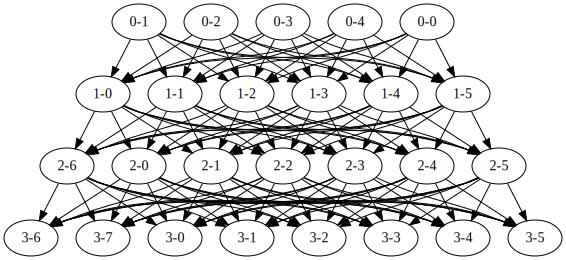

In [20]:
g = Digraph()

width = 8
height = 4
for L1 in range(height-1):
    L2 = L1 + 1
    for i in range(width-(height-L1-1)):
        for j in range(width-(height-L2-1)):
            node1 = str(L1)+"-"+str(i)
            node2 = str(L2)+"-"+str(j)
            g.edge(node1, node2)
g

Let's assume we are starting at the "0-1" node and we're searching for a path to "3-5", using BFS.  How big can `todo` get?

We could try to figure out what `f(N)` is, where `N` is the number of nodes in the graph, but this is a little naive.  The size of `todo` depends not just on the number of nodes, but their *shape*.

Let's use two variables to describe the size of the input (the graph):
* M will be the number of levels the graph
* N will be the widest level of the graph

Of course, not every kind of graph will fit so nicely into "levels" like this one, but we can define at least define M and N for this case.

If we're doing BFS, the memory complexity is `O(N)` because we never have nodes from more than two levels in `todo` at a time.

What if we're doing DFS?  Well, it depends on whether we are using the implementation with the `todo` stack or the recursive solution.  The `todo` stack version is pretty inneficient.  It's possible for almost all the nodes of the graph to be in `todo` at once, so the memory complexity is O(MN).

What about the recursive version of DFS?  For that, we don't have the `todo` stack.  However, there is a stack of frames, with a frame for each invocation.  Frames use memory.  The number of invocations/frames that can be on the stack at once corresponds to the number of levels in the above graph, which is M.  So the memory complexity of the recursive version is O(M).

What if instead of that nice graph with lots of connections between neat levels we have something that keeps branching out?  Such as a tree, or a graph that is close to a tree?

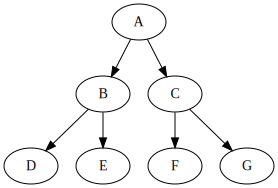

In [21]:
g = mygraph()
g.edge("A", "B")
g.edge("A", "C")
g.edge("B", "D")
g.edge("B", "E")
g.edge("C", "F")
g.edge("C", "G")
g

In this common case, DFS will be much more memory efficient, because the branching factor will make the tree much wider than it is deep.  In this case, if N is the number of nodes, BFS will be O(N) and recursive DFS will be O(log N).

## Priority Queues

A* ("A-start") is an important AI search algorithm: https://en.wikipedia.org/wiki/A*_search_algorithm that we won't learn in CS 320 (take CS 540 if you're interested).

This algorithm has something like a `todo` list for the search, but instead of a regular list, a structure called a *priority queue* is used.

To see why we would want this, let's look at a motivating case.  Consider this graph:

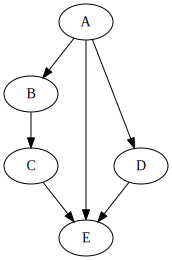

In [22]:
g = Digraph()
g.edge("A", "B")
g.edge("B", "C")
g.edge("C", "E")
g.edge("A", "D")
g.edge("D", "E")
g.edge("A", "E")
g

There are three paths from A to E:
1. A, B, C, E
2. A, E
3. A, D, E

Which path will DFS choose?  Which will BFS choose?

<details>
    <summary><b>ANSWER</b></summary>
      DFS will choose (1), BFS will choose (2)
</details>

Now what if we're trying to navitage between to points, and some roads/edges are longer than others:

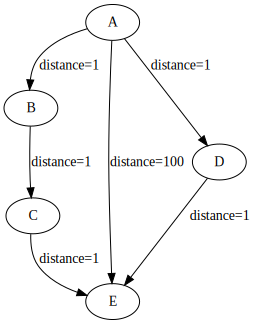

In [23]:
g = Digraph()
g.edge("A", "B", label="distance=1")
g.edge("B", "C", label="distance=1")
g.edge("C", "E", label="distance=1")
g.edge("A", "D", label="distance=1")
g.edge("D", "E", label="distance=1")
g.edge("A", "E", label="distance=100")
g

Which path do you prefer?  Unless you like the scenic route, presumably A,D,E -- the one than neither BFS or DFS chooses.

We need to base the order we explore nodes on distance.  Rather than popping from the front or end of `todo`, we want to pop closest first.  A priority queue is a structure that lets us do this.

Python's heapq functions can accomplish this: https://docs.python.org/3/library/heapq.html.  It doesn't need a special structure; it can cleverly arrange items in an underlying list to do this.

Let's try it:

In [24]:
from heapq import heappush, heappop

prioq = [] # regular list

heappush(prioq, 4)
heappush(prioq, 3)
heappush(prioq, 5)
heappush(prioq, 1)

print("QUEUE:", prioq)

print(heappop(prioq))
print(heappop(prioq))
print(heappop(prioq))

print("QUEUE:", prioq)
heappush(prioq, 2)
print("QUEUE:", prioq)

print(heappop(prioq))
print(heappop(prioq))

QUEUE: [1, 3, 5, 4]
1
3
4
QUEUE: [5]
QUEUE: [2, 5]
2
5


See how the smallest item remaining is always what you get with `heappop`?

You could logically accomplish the same by sorting the list each time before you want to do `.pop(0)`, but that would be WAY slower.

With the heapq implementation of priority queue, adding and removing items has O(log N) complexity (https://en.wikipedia.org/wiki/Binary_heap#Summary_of_running_times).  In contrast, sorting before each pop would have complexity O(N log N).  Ouch!

# Conclusion

There are many ways to techniques for searching through a graph for a value or a path that vary in terms of which nodes are explored first and the extra data structures needed for bookkeeping.  This simplest is probably recursive DFS (depth-first search); that one is also very memory efficient for graphs that branch out quickly but are not very deep.

Unfortunately, DFS isn't good at finding short paths.  BFS (breadth-first search) is guaranteed to find the shorter path.  On the other hand, it tends to be harder to implement, and the bookkeeping can take a lot of memory.

We also learned about three data structures that can be used to keep track of nodes to explore:
* stack (can be used for non-recursive DFS) -- a simple list makes a good stack
* queue (used for BFS) -- we use Python's deque implementation
* priority queue (used for A*, which we don't cover in CS 320) -- good for finding shortest path when some edges are "longer" than others